# ClimateLearn Quickstart

This notebook shows how to develop a weather forecasting model with deep learning in ClimateLearn from end-to-end. First, we install the library from the GitHub repository.

In [1]:
!pip install git+https://github.com/aditya-grover/climate-learn.git@v1-release

  Cloning https://github.com/aditya-grover/climate-learn.git (to revision v1-release) to /tmp/pip-req-build-m0wcd98y
  Running command git clone --filter=blob:none --quiet https://github.com/aditya-grover/climate-learn.git /tmp/pip-req-build-m0wcd98y
  Running command git checkout -b v1-release --track origin/v1-release
  Switched to a new branch 'v1-release'
  Branch 'v1-release' set up to track remote branch 'v1-release' from 'origin'.
  Resolved https://github.com/aditya-grover/climate-learn.git to commit 02470a6f8914b39d695c0073580caec9dd85daaa
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.1 MB/s

Mount the Google Drive file system, then import ClimateLearn and related libraries.

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [19]:
import climate_learn as cl
from climate_learn.data.processing.nc2npz import convert_nc2npz
from IPython.display import HTML
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichModelSummary,
    RichProgressBar
)
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
import torch

Download `2m_temperature` (_i.e._, surface temperature) data from the ERA5 dataset. For more info about ERA5, please see these links:
- https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.3803
- https://en.wikipedia.org/wiki/ECMWF_re-analysis

In this quickstart notebook, we use pre-processed ERA5 data provided by [WeatherBench](https://mediatum.ub.tum.de/1524895).

In [3]:
cl.data.download_weatherbench(
    dst="/content/drive/MyDrive/ClimateLearn/2m_temperature",
    dataset="era5",
    variable="2m_temperature"
)

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dataserv.ub.tum.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


The following function call processes the WeatherBench ERA5 data into a form that is easily ingestable for PyTorch models and defines the training-validation-testing splits. In addition, we shard the data to create sets of smaller files rather than one large file for each split.

In [16]:
convert_nc2npz(
    root_dir="/content/drive/MyDrive/ClimateLearn",
    save_dir="/content/drive/MyDrive/ClimateLearn/2m_temperature/processed",
    variables=["2m_temperature"],
    start_train_year=1979,
    start_val_year=2015,
    start_test_year=2017,
    end_year=2018,
    num_shards=16
)

100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


The downloaded and processed data is loaded into a PyTorch Lightning data module. In the following code cell, we use the following settings:
- `subsample = 6`. The dataset is subsampled at 6 hour intervals; this is done so that training is faster, but one could also use no subsampling (_i.e._, `subsample = 1`, which is the default).
- `pred_range = 24`. The model's objective is to predict `2m_temperature` 24 hours in the future.
- `history = 3`. When making a prediction, the model is given data at time `t`, `t-subsample`, and `t-subsample*2`.

In [5]:
dm = cl.data.IterDataModule(
    "direct-forecasting",
    "/content/drive/MyDrive/ClimateLearn/2m_temperature/processed",
    "/content/drive/MyDrive/ClimateLearn/2m_temperature/processed",
    ["2m_temperature"],
    ["2m_temperature"],
    src="era5",
    subsample=6,
    pred_range=24,
    history=3,
    batch_size=32
)
dm.setup()

Run baseline methods, climatology and persistence. Climatology uses the average value observed in the training data as its predictions. Persistence uses the last observed value as its prediction (for our setup, that would mean using the values of `2m_temperature` at time `t` as the prediction for time `t+24`).

In [6]:
climatology = cl.load_forecasting_module(data_module=dm, preset="climatology")
persistence = cl.load_forecasting_module(data_module=dm, preset="persistence")

trainer = pl.Trainer()
trainer.test(climatology, dm)
trainer.test(persistence, dm)

Loading preset: climatology
Using preset optimizer
Using preset learning rate scheduler
Loading training loss: lat_mse
No train transform
Loading validation loss: lat_rmse
Loading validation loss: lat_acc
Loading validation loss: lat_mse
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Loading test loss: lat_rmse
Loading test loss: lat_acc
Loading test transform: denormalize
Loading test transform: denormalize
Loading preset: persistence
Using preset optimizer
Using preset learning rate scheduler
Loading training loss: lat_mse
No train transform
Loading validation loss: lat_rmse
Loading validation loss: lat_acc
Loading validation loss: lat_mse
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: lat_rmse
Loading test loss: lat_acc
Loading test transform: denormalize
Loading test transform: denormalize


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test/lat_acc:2m_temperature  │    -0.005340531784889044     │
│    test/lat_acc:aggregate    │    -0.005340531784889044     │
│ test/lat_rmse:2m_temperature │      5.8257582160091745      │
│   test/lat_rmse:aggregate    │      5.8257582160091745      │
└──────────────────────────────┴──────────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test/lat_acc:2m_temperature  │      0.9154197698131833      │
│    test/lat_acc:aggregate    │      0.9154197698131833      │
│ test/lat_rmse:2m_temperature │      2.120680465905983       │
│   test/lat_rmse:aggregate    │      2.120680465905983       │
└──────────────────────────────┴──────────────────────────────┘

[{'test/lat_rmse:2m_temperature': 2.120680465905983,
  'test/lat_rmse:aggregate': 2.120680465905983,
  'test/lat_acc:2m_temperature': 0.9154197698131833,
  'test/lat_acc:aggregate': 0.9154197698131833}]

ClimateLearn provides standard metrics. For forecasting, it displays the latitude weighted RMSE and the latitude weighted ACC. Lower RMSE is better, while higher ACC is better. ACC has a range of [0, 1]. We use latitude weighting to adjust for the fact that we flatten the curved surface of the Earth to a 2D grid, which is squishes information at the equator and stretches information near the poles. For more info about these metrics, see this link: https://geo.libretexts.org/Bookshelves/Meteorology_and_Climate_Science/Practical_Meteorology_(Stull)/20%3A_Numerical_Weather_Prediction_(NWP)/20.7%3A_Forecast_Quality_and_Verfication

Also, you might notice the metrics with `aggregate` as the suffix. Since we are considering just one variable in this quickstart notebook, the `aggregate` metrics are the same as the `2m_temperature` metrics. However, if you would like to use more variables (_e.g._, `geopotential`, `humidity`), then the `aggregate` metrics would represent an average. For example, `lat_rmse:aggregate` would be the average of `lat_rmse:2m_temperature`, `lat_rmse:geopotential`, and `lat_rmse:humidity`.

Besides these metrics, ClimateLearn also provides visualization tools. In the following cell, we first get the denormalization tranfsorm to transform the data returned by the PyTorch Lightning data module, which was normalized to $\mathcal{N}(0,1)$, back into its original range. As we can see the logging messages displayed in the previous cell's output, the persistence model's 0-th test tranfsormation is denormalization.

Then, we visualize the ground truth, prediction, and bias for the persistence prediction made on the 0-th sample of the testing set. Bias is defined as predicted minus observed (see the link provided above). It is useful to gain a visual understanding of model performance. In this example, we can see that persistence generally underpredicts the true values.

For weather forecasting with history greater than 1, the visualization function also returns a value which we save here as `in_graphic`. This graphic can be animated, as seen in the next code cell.

0it [00:00, ?it/s]


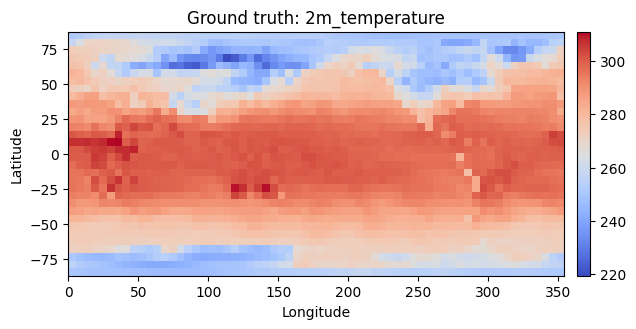

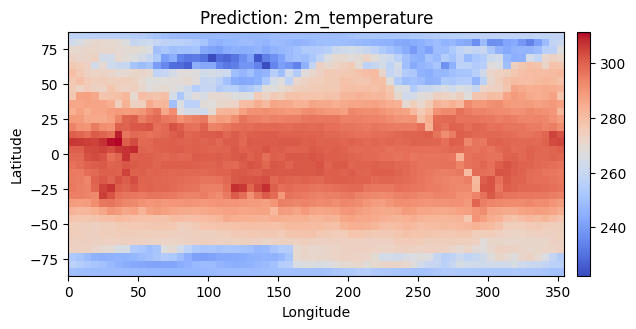

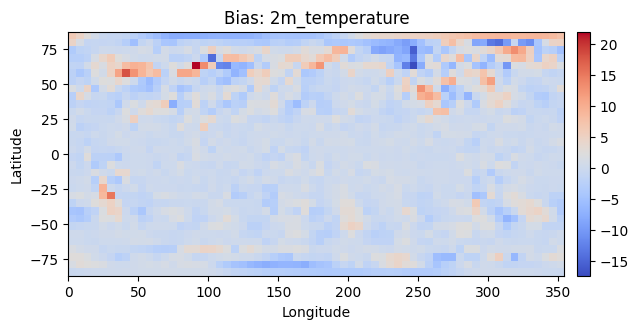

In [20]:
denorm = persistence.test_target_transforms[0]
in_graphic = cl.utils.visualize_at_index(
    persistence,
    dm,
    in_transform=denorm,
    out_transform=denorm,
    variable="2m_temperature",
    src="era5",
    index=0
)

In [21]:
HTML(in_graphic.to_jshtml())

Moreover, ClimateLearn can display the mean bias, which is the average bias at each coordinate across the entire testing set.

43it [00:00, 49.81it/s]


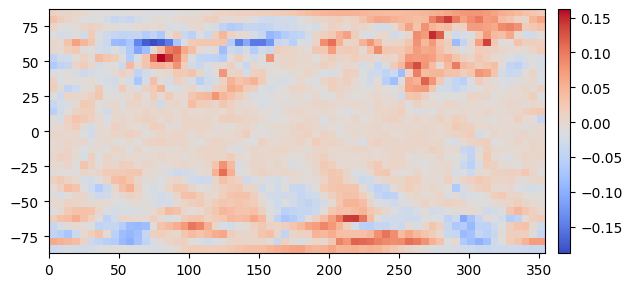

In [22]:
cl.utils.visualize_mean_bias(
    dm,
    persistence,
    out_transform=denorm,
    variable="2m_temperature",
    src="era5"
)

Next, we can train a deep learning model to do weather forecasting. In the following code cell, we load the ResNet-based model architecture defined by [Rasp & Theurey, 2020](https://arxiv.org/abs/2008.08626).

In [7]:
resnet = cl.load_forecasting_module(
    data_module=dm,
    preset="rasp-theurey-2020"
)

Loading preset: rasp-theurey-2020
Using preset optimizer
Using preset learning rate scheduler
Loading training loss: lat_mse
No train transform
Loading validation loss: lat_rmse
Loading validation loss: lat_acc
Loading validation loss: lat_mse
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: lat_rmse
Loading test loss: lat_acc
Loading test transform: denormalize
Loading test transform: denormalize


To train the model, we leverage PyTorch Lightning for GPU acceleration, specification of floating-point precision (we use 16-bit here to speed up training), and callbacks such as early stopping, model checkpointing, and logging to TensorBoard. Recall from previous text cells why we use `lat_mse:aggregate` as the early stopping criterion. For sake of example, we train for just one epoch, but to obtain good results, one should train for much longer.

In [16]:
pl.seed_everything(0)
default_root_dir = f"resnet_forecasting_24hrs"
logger = TensorBoardLogger(save_dir=f"{default_root_dir}/logs")
early_stopping = "val/lat_mse:aggregate"
callbacks = [
    RichProgressBar(),
    RichModelSummary(max_depth=1),
    EarlyStopping(
        monitor=early_stopping,
        patience=5
    ),
    ModelCheckpoint(
        dirpath=f"{default_root_dir}/checkpoints",
        monitor=early_stopping,
        filename="epoch_{epoch:03d}",
        auto_insert_metric_name=False,
    )
]
trainer = pl.Trainer(
    logger=logger,
    callbacks=callbacks,
    default_root_dir=default_root_dir,
    accelerator="gpu" if torch.cuda.is_available() else None,
    devices=[0] if torch.cuda.is_available() else None,
    max_epochs=1,
    precision="16"
)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:555: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(resnet, datamodule=dm)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:52: UserWarning: Detected 
KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")

After fitting the model, we can test it using the best checkpoint saved during training.

In [18]:
trainer.test(resnet, datamodule=dm, ckpt_path="best")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/resnet_forecasting_24hrs/checkpoints/epoch_000.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/resnet_forecasting_24hrs/checkpoints/epoch_000.ckpt


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test/lat_acc:2m_temperature  │      0.9205609543165262      │
│    test/lat_acc:aggregate    │      0.9205609543165262      │
│ test/lat_rmse:2m_temperature │      2.0220704285816558      │
│   test/lat_rmse:aggregate    │      2.0220704285816558      │
└──────────────────────────────┴──────────────────────────────┘

[{'test/lat_rmse:2m_temperature': 2.0220704285816558,
  'test/lat_rmse:aggregate': 2.0220704285816558,
  'test/lat_acc:2m_temperature': 0.9205609543165262,
  'test/lat_acc:aggregate': 0.9205609543165262}]

As before, let's visualize the bias of our deep learning model on the first sample of the testing set (the mean bias computation will take a while, even on GPU).

0it [00:00, ?it/s]


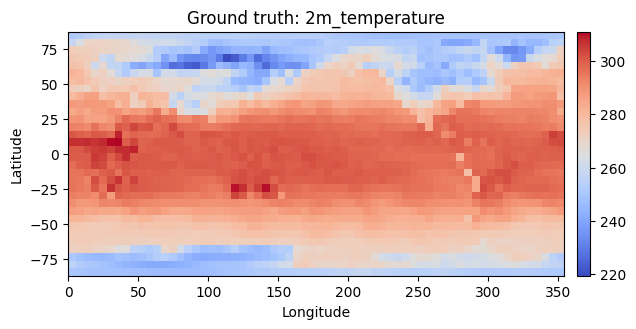

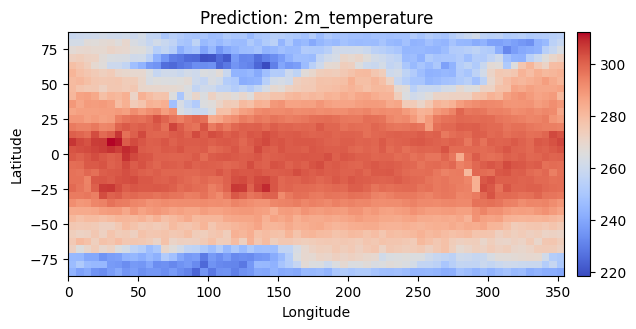

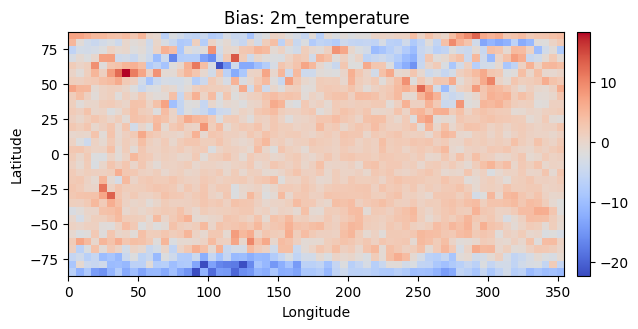

In [25]:
denorm = resnet.test_target_transforms[0]
in_graphic = cl.utils.visualize_at_index(
    resnet.to(device="cuda:0"),
    dm,
    in_transform=denorm,
    out_transform=denorm,
    variable="2m_temperature",
    src="era5",
    index=0
)

Congratulations on completing this quickstart of ClimateLearn. In this tutorial, we used ClimateLearn to download and process data from ERA5. Then, we evaluated two baseline methods, persistence and climatology, followed by visualizations of persistence's bias on one specific testing sample and its mean bias across all testing samples. Finally, we trained a deep learning model and visualized its mean bias too.

Since ClimateLearn was designed to be plug-and-play, each step of this pipeline can be customized.

- Instead of using ERA5 data for forecasting, maybe you would like to use data from CMIP6. Specifically, ClimateLearn supports downloading and processing data from the [MPI-ESM1.2-HR](https://agupubs.onlinelibrary.wiley.com/doi/toc/10.1002/\(ISSN\)1942-2466.MPIESM1-2) model with the following function `cl.data.download_mpi_esm1_2_hr`.
- Or, instead of doing `direct-forecasting`, you could perform `continuous-forecasting` or `iterative-forecasting` by swapping out the first argument to the constructor of `cl.data.IterDataModule`.
- You could also change the deep learning model, optimizer, and learning rate scheduler by loading a different preset or specifying your own bespoke solutions like:
```python
model = cl.load_forecasting_module(
    data_module=dm,
    model="resnet",
    model_kwargs={"n_blocks": 4, "history": 5},
    optim="adamw",
    optim_kwargs={"lr": 5e-4},
    sched="linear-warmup-cosine-annealing",
    sched_kwargs={"warmup_epochs": 5, "max_epochs": 50}
)
```

The source code for ClimateLearn is publicly available on GitHub at https://github.com/aditya-grover/climate-learn, and the documentation website is https://climatelearn.readthedocs.io/.